# Multivariate metric "version 2"
Currently still experimental version of the "multivatiate" metric. Quantifies correspondence of phenotype profiles to ground truth biology functional relationships. This code differs from the previous version in the use of a graph adjacency matrix, leading to a (perhaps) better definition of prediction and ground truth.

The previous metric searches for biologically related genes within the k% genes most similar to the query gene. This has been observed to include gene pairs with quite low similarity. To mitigate this, this code has an extra option "`relative`", that by default emulates the previous behavior (`relative==True`), but can be set to `False` in order to search within the k% most globally similat gene pairs.

In [30]:
import os
from typing import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm, trange
import scanpy as sc
from anndata import AnnData

import sys
sys.path.append("..") 
from Templates.tools import multivariate2

In [19]:
ED_file = "/gstore/data/project/crc_recursion_gw/crc-NGS5186//DS000015231/qc_embedding.h5ad"
scvi_file = "/gstore/data/project/crc_recursion_gw/crc-NGS5186//DS000015231/qc_embedding_scvi.h5ad"

In [20]:
adata = sc.read_h5ad(scvi_file)

In [21]:
adata

AnnData object with n_obs × n_vars = 447517 × 32011
    obs: 'Sample', 'Barcode', 'DemuxType_crispr', 'DemuxAssignment_crispr', 'DemuxType_hashing', 'DemuxAssignment_hashing', 'cellline', 'timepoint', 'gene_symbol', 'class', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'S_score', 'G2M_score', 'phase', 'SCN_class'
    var: 'Symbol'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [36]:
genes = list(set(adata.obs.gene_symbol))

In [37]:
pert_embeddings = {}

for i, gene in enumerate(genes):
    pert_embeddings[gene] =  adata[adata.obs.gene_symbol.isin([gene])].obsm["X_scVI"].mean(0)
    


In [49]:
df = pd.DataFrame.from_dict(pert_embeddings,orient='index')

In [50]:
df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
KLK3,-0.059668,0.083423,0.092964,-0.050321,0.126157,0.026482,-0.032168,0.042822,-0.035636,-0.003789,...,-0.059941,-0.073726,0.100717,0.046453,0.016907,-0.030219,-0.005731,-0.100525,0.047507,0.137713
FAM135A,-0.054811,-0.138726,0.012547,0.049380,-0.049482,0.069743,0.025186,0.000221,-0.158578,-0.064813,...,-0.097782,0.016458,-0.068107,0.056153,0.189792,0.068976,0.057519,-0.109697,-0.146422,0.151680
COL23A1,0.083099,-0.051722,-0.060800,-0.037766,-0.019290,0.106241,0.058852,0.027982,-0.099682,-0.056901,...,-0.027145,-0.028099,0.079111,-0.214425,0.014260,0.068083,-0.022817,-0.143385,-0.006624,0.027437
RANBP1,0.157588,-0.021456,-0.021946,-0.142267,0.077648,0.031533,-0.345125,-0.202374,0.071791,-0.245099,...,0.111761,-0.112197,-0.042576,-0.111732,-0.017714,-0.093625,-0.139252,0.119390,0.145721,0.169987
ENSG00000275674_4,-0.579714,0.174480,-0.524961,-0.383597,0.645416,0.320042,-0.085246,0.620110,-0.182559,0.859524,...,-0.608380,-0.721295,0.112811,0.763372,0.187407,1.170057,-0.216284,0.111312,-0.343802,0.178194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OR2L13,0.125993,-0.073525,-0.123788,0.048277,0.029510,0.014639,0.113047,-0.019521,0.056538,0.104059,...,-0.041863,0.055707,-0.022285,0.020082,0.083966,0.077454,-0.072524,-0.063449,-0.000603,0.280579
GSG1L2,0.130011,-0.134724,0.090870,0.030979,-0.068209,-0.125922,-0.037193,0.081902,0.008038,0.192830,...,-0.315316,0.108971,-0.019432,0.151986,0.161502,0.088752,-0.020425,0.256978,-0.225931,0.110166
FDFT1,0.032138,0.387162,0.195819,0.094464,0.101408,-0.253202,-0.166077,0.281342,-0.479888,-0.105462,...,0.086324,-0.081277,0.132423,0.028923,-0.407871,0.032733,-0.030325,0.121323,-0.106191,-0.332730
CLYBL,0.066655,-0.046660,-0.027880,0.053893,-0.043131,-0.071240,-0.058755,-0.139231,-0.024839,0.022425,...,-0.197109,0.093045,-0.058742,0.050827,-0.140622,-0.111719,0.090832,0.040069,-0.100354,0.169701


## Load data
Data is expected to be a `pandas.DataFrame` with every column a feature and an additional index column holding the gene symbol.

In [2]:
#data = pd.read_parquet("/home/hoeckenb/scratch/funk22-interphase-pca09-agg.parquet", engine="pyarrow")
#data = pd.read_parquet("/home/hoeckenb/scratch/funk22-interphase-agg-pc90.parquet", engine="pyarrow")
#data.head()

,PC-000,PC-001,PC-002,PC-003,PC-004,PC-005,PC-006,PC-007,PC-008,PC-009,...,PC-157,PC-158,PC-159,PC-160,PC-161,PC-162,PC-163,PC-164,PC-165,PC-166
gene_symbol_0,,,,,,,,,,,,,,,,,,,,,
AAAS,1.106867,-0.747926,1.155240,-0.491365,0.456901,0.963583,0.718383,0.349782,-0.219393,1.113104,...,0.026250,-0.021938,-0.001599,-0.031905,-0.038126,-0.007787,-0.049494,-0.015709,-0.049985,0.055856
AAGAB,-0.210318,-0.966152,0.314909,-0.474881,-0.320832,0.958050,0.470686,0.424978,0.049498,-0.096290,...,0.051646,0.016336,0.009510,-0.029496,0.013233,0.026944,-0.049906,0.015041,-0.001380,0.026290
AAK1,1.455008,-1.949138,0.269986,-0.736839,-0.090864,0.233727,0.332653,0.638721,-0.102166,0.626261,...,0.017350,0.005198,0.015608,-0.004582,0.006712,0.007854,-0.057570,-0.011102,-0.031071,0.032986
AAMP,0.924512,-3.091321,-1.492933,-1.409231,1.894559,-2.033067,0.828264,0.035249,-0.257012,-0.525875,...,0.012042,-0.011472,0.003457,-0.013985,0.016885,0.006622,-0.063554,0.009859,-0.019008,0.023797
AARS1,-0.080834,0.386941,-0.133690,-1.026175,-0.252491,-1.015047,0.544481,0.012693,0.070617,0.705184,...,-0.007424,0.009117,-0.003316,0.018584,0.028190,0.017503,-0.051752,-0.017451,-0.025344,0.029942


In [51]:
data= df.copy()

## Center data
In this case using the global center

In [52]:
data -= np.mean(data.to_numpy(), 0).reshape(1, -1)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
KLK3,-0.074676,0.081323,0.114752,-0.047507,0.119314,0.045419,-0.029882,0.076807,-0.028600,0.001606,...,-0.037281,-0.096635,0.085667,0.072719,0.036161,-0.023508,-0.007730,-0.105664,0.106828,0.081724
FAM135A,-0.069819,-0.140825,0.034336,0.052194,-0.056326,0.088680,0.027471,0.034205,-0.151542,-0.059418,...,-0.075122,-0.006451,-0.083157,0.082420,0.209046,0.075688,0.055520,-0.114835,-0.087101,0.095692
COL23A1,0.068091,-0.053822,-0.039012,-0.034951,-0.026133,0.125178,0.061138,0.061967,-0.092646,-0.051506,...,-0.004485,-0.051007,0.064061,-0.188159,0.033514,0.074795,-0.024816,-0.148524,0.052697,-0.028551
RANBP1,0.142580,-0.023556,-0.000158,-0.139453,0.070805,0.050471,-0.342839,-0.168389,0.078827,-0.239704,...,0.134421,-0.135106,-0.057626,-0.085465,0.001540,-0.086913,-0.141251,0.114251,0.205041,0.113998
ENSG00000275674_4,-0.594722,0.172380,-0.503172,-0.380783,0.638573,0.338979,-0.082960,0.654095,-0.175523,0.864918,...,-0.585720,-0.744203,0.097761,0.789638,0.206661,1.176768,-0.218283,0.106173,-0.284482,0.122205


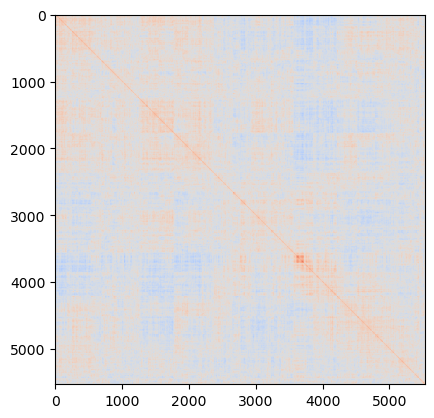

In [53]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import scipy.cluster.hierarchy as sch


def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly
    correlated variables are next to eachother

    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix

    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method="complete")
    cluster_distance_threshold = pairwise_distances.max() / 2
    idx_to_cluster_array = sch.fcluster(
        linkage, cluster_distance_threshold, criterion="distance"
    )
    idx = np.argsort(idx_to_cluster_array)

    if not inplace:
        corr_array = corr_array.copy()

    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :], idx_to_cluster_array
    return corr_array[idx, :][:, idx], idx_to_cluster_array


def corr_map(data):
    cm = cosine_similarity(data.to_numpy())
    cm = pd.DataFrame(cm, index=data.index, columns=data.index)
    cm, clusters = cluster_corr(cm)
    return cm, clusters


similarity_matrix, _ = corr_map(data)

plt.imshow(similarity_matrix, vmin=-1, vmax=1, cmap="coolwarm")

In [54]:
corum = multivariate2.parse_geneset("./data/CORUM.txt")
adj_coords = multivariate2.adjacency_coords(corum, similarity_matrix)

metrics = multivariate2.precision_recall(similarity_matrix, adj_coords, relative=True, verbose=False, excl=True)
metrics

  0%|          | 0/10 [00:00<?, ?it/s]

,percentile,precision,recall,f1,total_pairs,total_positives,total_negatives,true_positives,false_positives,true_negatives,false_negatives
0,90.0,0.032456,0.292365,0.058426,127765.0,1611.0,126154.0,471.0,14041.0,112113.0,1140.0
1,91.0,0.033682,0.275605,0.060028,127765.0,1611.0,126154.0,444.0,12738.0,113416.0,1167.0
2,92.0,0.035787,0.262570,0.062989,127765.0,1611.0,126154.0,423.0,11397.0,114757.0,1188.0
3,93.0,0.038749,0.251397,0.067147,127765.0,1611.0,126154.0,405.0,10047.0,116107.0,1206.0
4,94.0,0.042229,0.238982,0.071775,127765.0,1611.0,126154.0,385.0,8732.0,117422.0,1226.0
5,95.0,0.046716,0.224705,0.077350,127765.0,1611.0,126154.0,362.0,7387.0,118767.0,1249.0
6,96.0,0.051423,0.202980,0.082058,127765.0,1611.0,126154.0,327.0,6032.0,120122.0,1284.0
7,97.0,0.057735,0.176288,0.086983,127765.0,1611.0,126154.0,284.0,4635.0,121519.0,1327.0
8,98.0,0.069339,0.147114,0.094253,127765.0,1611.0,126154.0,237.0,3181.0,122973.0,1374.0
9,99.0,0.085992,0.098696,0.091908,127765.0,1611.0,126154.0,159.0,1690.0,124464.0,1452.0


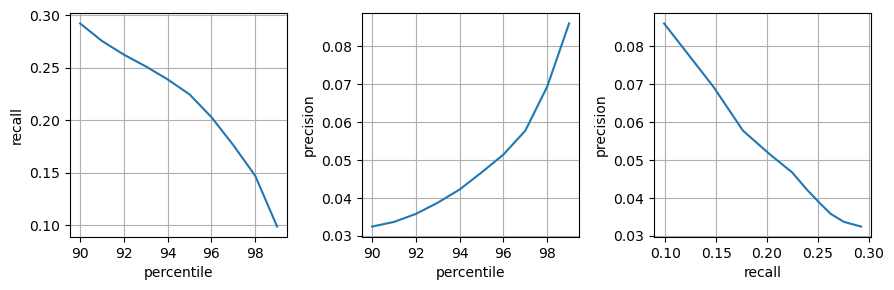

In [55]:
_, axs = plt.subplots(1, 3, figsize=np.array([3, 1]) * 3)
xy = [("percentile", "recall"), ("percentile", "precision"), ("recall", "precision")]
for (x, y), ax in zip(xy, axs.flat):
    ax.plot(metrics[x], metrics[y])
    ax.grid()
    ax.set_xlabel(x)
    ax.set_ylabel(y)
plt.tight_layout()